In [39]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings 
from sklearn.model_selection import train_test_split 
from lightgbm import LGBMClassifier as LGBMC 
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
import lightgbm as lgb 
import optuna 
from sklearn.metrics import accuracy_score, roc_auc_score,precision_score, confusion_matrix,recall_score 

In [40]:
df=pd.read_csv('/dshome/WoongLab/heo/construction_oil/waterportability_total/water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [42]:
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [43]:
df["ph"].fillna(value = df["ph"].median(), inplace = True)

In [44]:
df["Sulfate"].fillna(value = df["Sulfate"].median(), inplace = True)

In [45]:
df["Trihalomethanes"].fillna(value = df["Trihalomethanes"].median(), inplace = True)

In [46]:
df.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [47]:
# split data into X and y
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [48]:
def y_label_count(df):
    colors=['lightsteelblue','#FD9F31']
    wedgeprops={'width':0.7, 'edgecolor': 'k', 'linewidth':0.75}
    plt.subplots(figsize=(8,8))
    plt.title('Ratio of Y_LABEL in Total Data', fontsize=20, fontdict={'weight':'bold'})
    plt.rc('font', size=12)
    labels=['0','1']
    plt.pie(df['Potability'].value_counts(),
            autopct="%.2f%%",shadow=True,startangle=90, textprops={'fontsize':15},
            colors=colors, wedgeprops=wedgeprops, labels=labels)
    plt.tight_layout()
    plt.show()
    
    print('전체 데이터 수:', len(df['Potability']))
    print('전체 데이터 중 안전하게 마실 수 없는 물의 수: ', df['Potability'].value_counts()[0])
    print('전체 데이터 중 안전하게 마실 수 있는 물의 수: ', df['Potability'].value_counts()[1])

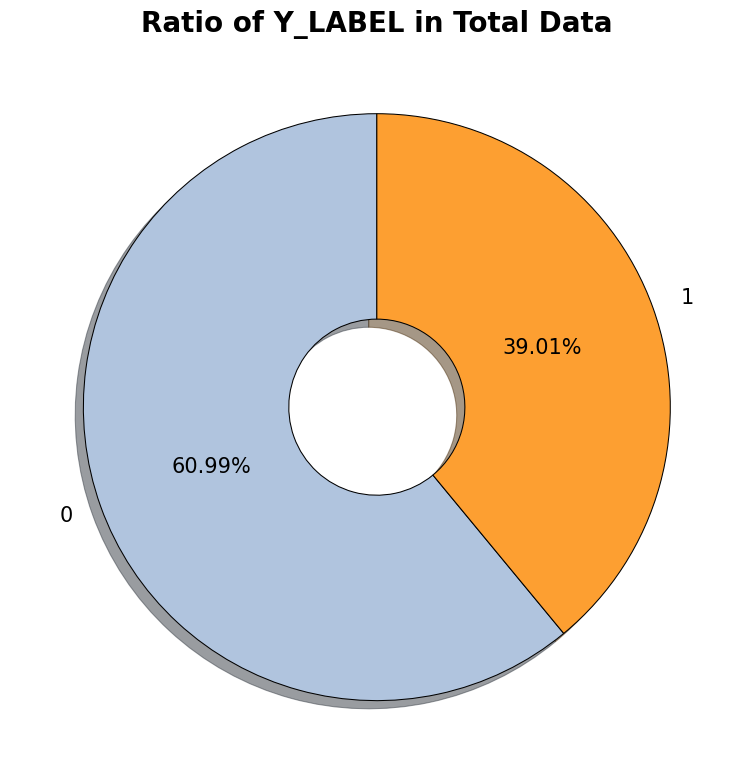

전체 데이터 수: 3276
전체 데이터 중 안전하게 마실 수 없는 물의 수:  1998
전체 데이터 중 안전하게 마실 수 있는 물의 수:  1278


In [49]:
y_label_count(df)

In [50]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [51]:
train_y.value_counts()

0    1598
1    1022
Name: Potability, dtype: int64

In [52]:
# class weight 적용하기 위해 y label의 비율을 구하기

ratio=train_y.value_counts()[0]/train_y.value_counts()[1]

## 베이지안 최적화해주기 - LightgbmClassifier

**1. 5-fold 교차검증 이용해서 Train data로 Validation set을 Auc가 최고였을 때의 하이퍼파라미터 구하기**

**2. Learning rate 0.01~0.1, max_depth 3~9, n_estimators 100~1000이었을 때에서 가장 최적의 하이퍼파라미터 구하기**

In [31]:
def objective(trial):
    # Define hyperparameters to optimize 
    params={
        'boosting_type':'gbdt',
        'objective':'binary',
        'metric':'binary_logloss',
        'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
        'max_depth':trial.suggest_int('max_depth',3,9),
        'n_estimators':trial.suggest_int("n_estimators",100,1000)
    }
    # Train and evaluate model 
    lgb_cv=lgb.LGBMClassifier(**params, random_state=42,scale_pos_weight=ratio)
    scores=cross_val_score(lgb_cv,train_X,train_y,cv=5,scoring='roc_auc')
    auc=scores.mean()
    return auc 

# Define study object and optimize 

study=optuna.create_study(direction='maximize',study_name='lgb_boost_opt',load_if_exists=True)
study.optimize(objective, n_trials=50)

# Print best hyperparameters and auc
print(f'Best hyperparameters: {study.best_params}')
print(f'Best AUC: {study.best_value:.4f}')

[I 2023-04-30 01:53:55,049] A new study created in memory with name: lgb_boost_opt
/tmp/ipykernel_888652/2141867322.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-04-30 01:53:56,288] Trial 0 finished with value: 0.6263915085588483 and parameters: {'learning_rate': 0.010361999465015382, 'max_depth': 3, 'n_estimators': 566}. Best is trial 0 with value: 0.6263915085588483.
/tmp/ipykernel_888652/2141867322.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate':trial.suggest_loguniform('learning_rate',0.01,0.1),
[I 2023-04-30 01:54:00,975] Trial 1 finished 

Best hyperparameters: {'learning_rate': 0.012420492995755913, 'max_depth': 9, 'n_estimators': 125}
Best AUC: 0.6791


In [53]:
lgb=lgb.LGBMClassifier(learning_rate= 0.012420492995755913,max_depth=9,n_estimators=125,scale_pos_weight=ratio,random_state=42)

In [54]:
# 모델 학습하기

lgb.fit(train_X,train_y)

LGBMClassifier(learning_rate=0.012420492995755913, max_depth=9,
               n_estimators=125, random_state=42,
               scale_pos_weight=1.563600782778865)

In [55]:
train_prob=pd.DataFrame()
train_prob['prob']=lgb.predict_proba(train_X)[:,1]

In [56]:
# 오즈(odds) 구하기

train_prob['1_prob']=1-train_prob['prob']
train_prob['odds']=train_prob['prob']/train_prob['1_prob']

In [57]:
# 앞에서 구한 오즈로 로짓을 구하기

train_prob['loogits']=np.log(train_prob['odds'])

In [82]:
# loogits으로 test data의 예측확률 값을 구하기

train_prob['new_prob']=1/(1+np.exp(-train_prob['loogits']/0.1))

In [83]:
import optuna
from lightgbm import LGBMRegressor

model2 = LGBMRegressor(learning_rate= 0.012420492995755913,max_depth=3,n_estimators=125)

In [84]:
model2.fit(train_X,train_prob['new_prob'])

LGBMRegressor(learning_rate=0.012420492995755913, max_depth=3, n_estimators=125)

In [85]:
# model로 new_test_data_X로 predict하기

test_data=pd.DataFrame()
test_data['prob']=model2.predict(test_X)

In [86]:
# 모델 성능 평가함수 만들기

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

def get_clf_prob(y_test, probability):
  pred=np.where(probability > 0.5,1,0)
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test,pred)
  precision=precision_score(y_test,pred) 
  recall=recall_score(y_test,pred) 
  # F1 스코어 추가 
  f1=f1_score(y_test,pred,average='macro')
  Roc_score=roc_auc_score(y_test,probability)
  print('임계값: ', 0.5) 
  print('오차행렬')
  print(confusion) 
  # f1 score print 추가 
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, AUC:{4: .4f}'.format(accuracy,precision,recall,f1,Roc_score))

In [87]:
# 모델 평가하기

get_clf_prob(test_y,test_data['prob'])

임계값:  0.5
오차행렬
[[355  45]
 [189  67]]
정확도: 0.6433, 정밀도: 0.5982, 재현율: 0.2617, F1:0.5581, AUC: 0.6369
